# Welcome to the 4DVar tutorial
***

In this tutorial we will explore the basic features of 4DVar, using the quasi-geostrophic model. **It is recommended that you run the 3DVar tutorial first**. The model mimics the evolution of large-scale features, such as high and low pressure cells in the atmosphere. In the following we first provide a short description of the 4DVar problem and of the quasi-geostrophic model and what it represents, followed by the data-assimilation experiments.

## Introduction to 4DVar

*For those familiar with the 4DVar data-assimilation method this section can be skipped.* <br>
Strong constraint 4DVar is a data-assimilation method that solves the data-assimilation problem at a given point in time, but using observations gathered over a time window. (Another, similar, method is Weak-constraint 4DVar that updates the state over the whole time window by also estimating errors in the model equations, which will be discussed in another tutorial.) The basic idea is that we have a first guess of the atmospheric state from a model forecast $x_b$, and want to update this state with a set of observations $y$ obtained over a time window $[0,T]$. These observations are from the evolution of the unknown true atmospheric state over this time window, and the measurement process is described by 
<br><br>
<center>$y = H(x_{true}) + \epsilon_{true}$ </center> 
<br>
in which $H(..)$ is the so-called observation operator that maps a state $x$ {\em at the beginning of the time window} to observation space. Observation space in this case contains observations valid over the whole time window. This means that to compare the model state with the observations $H$ has first bring the model state to the observation time, and then extract from the state at that time the corresponding modelled observation. {\em This means that $H$ now contains the model operator.} The $\epsilon_{true}$ is the observation error. This error is due to the measurement process itself: every measurement will have an error related to the precision of the measurement. There is also another part to this error, called the representation error, that we will not discuss here as it is not essential for understanding 4DVar. <br><br>
The 4DVar tries to find the state that is both close to our first guess $x_b$ at the start of the window and when modeled forward in time is close to the observations $y$. As in 3DVar we can set up a cost function as
<br><br>
<center>$J(x) = (x-x_b)^TB^{-1}(x-x_b) + \left(y-H(x)\right)^T R^{-1}\left(y-H(x)\right)$ </center> <br>
The deviation of $x$ from $x_b$ is weighted by the first-guess error covariance $B$, and deviation of the forecast of $x$ to the observation times and the actual observations $y$ is weighted by the observation error covariance. The gradient of the cost function is given by 
<br><br>
<center>$\frac{d J(x)}{dx} = 2B^{-1}(x-x_b) - 2H^T R^{-1}\left(y-H(x)\right)$ </center> 
<br>
Note the similarity with the 3DVar gradient. The only difference is that $H$ now contains the model operator. 

When $H$ is linear we can write down the solution, putting the gradient to zero and gathering all term with $x$ on one side, as:
<br><br>
<center>$x_a = x_b + \left(B^{-1}+H^TR^{-1}H \right)^{-1}H^T R^{-1}(y-Hx_b)$ </center> 
<br>
Again the same expression as for 3DVar, but with $H$ containing the model equations. We can understand this equation by reading it from right to left. First, we calculate the innovation at observation time (remember that $H$ contains the model to bring $x_b$ to the observation times). This innovation is scaled by $R^{-1}$ and then multiplied by $H^T$. This operator is the transpose of $H$, which means instead of moving forward in time with the model, we move backward in time, all the easy to the beginning of the time window. There we scale again, this time using both $B$, which is valid at the beginning of the window, and $H^TR^{-1}H$. This latter matrix is the observation error covariance, which is valid at observation times, transported to the beginning of the time window via $H^T$ (and its transpose on the other side of $R$). This is the process by which observation information is carried from the observation time to the beginning of the time window.<br>

When $H(..)$ is nonlinear we cannot write down an explicit solution, and instead have to use iterative methods to solve this problem. The standard method to do this in Strong-constraint 4DVar is via Gauss-Newton iteration. The Gauss-Newton iteration is an approximation to the Newton iteration method in which the term in the Hessian that contains the second order derivative of $H$ is neglected. We will not go into details here, but the point is that we can write the solution to the full non-quadratic cost function as a sequence of solutions of a set of quadratic cost functions. This is called {\em incremental 4DVar}. The quadratic cost function at iteration $i$ look like
<br><br>
<center>$J(\delta x) = (\delta-\xi^{(i)}) x^TB^{-1}(\delta-\xi^{(i)}) + \left(H\delta x - d\right)^T R^{-1}\left(H\delta x - d\right)$ </center> <br>
in which $\delta x = x - x^{(i)}$, where $x^{(i)}$ is the vector $\xi^{(i)}=x_b-x^{(i)}$ and $H$ is now the linearized observation operator, linearized along the nonlinear trajectory of the model from starting point $x_b^{(i)}$. The observation is transformed to $d=y-H(x^{(i)})$.<br>

Each of these incremental cost functions have the same form as when $H$, so the model and the mapping to observation space at observation time, is linear. Hence, we can write for the solution:
<br><br>
<center>$\delta x = \xi^{(i)}  + \left(B^{-1}+H^TR^{-1}H \right)^{-1}H^T R^{-1}(d - Hx^{(i)})$ </center> 
<br>
Although the solution looks nice, it is actually troublesome because of the $H^T$ operator. As mentioned, it contains the model, but linearized, and transposed. The transpose is easy when $H$ is a matrix, but we don't have it as a matrix (it would be too large to store). Instead, we have it as a linear operator working on a vector. The transpose of an operator is called the adjoint operator, and it involves the adjoint of the linearized model equations. To make progress, we introduce the linearized model equation
<br><br>
<center>$\delta x_{t+1} = M_{t} \delta x_t$ </center> 
<br>

The problem is typically solved using Lagrange multipliers to ensure that these model equations are fulfilled when solving the incremental 4DVar cost function. This is a standard trick in variational calculus. To this end we modify this cost function to
<br><br>
<center>$J(\delta x, \lambda) = (\delta x_0-\xi^{(i)}) x^TB^{-1}(\delta x_0-\xi^{(i)}) + \sum_{t=1}^T  \left(H_t\delta x_t - d_t\right)^T R^{-1}\left(H_t\delta x_t - d_t\right) + \sum_{t=1}^T \lambda_t (\delta x_{t} - M_{t-1} \delta x_{t-1})$ </center> 
<br>
in which we introduced the time index, and also defined $H_t$ as the mapping from model space to observation space at time $t$. If we now set the derivative of $J$ to all $\delta x_t$ and all $\lambda_t$ equal to zero we obtain the so-called Euler-Lagrange equations
<br><br>
<center>
\begin{align}
 \delta x_0 &= \xi^{(i)} + B \lambda_0 \\
 \delta x_{t+1} &= M_t^{(i)} \delta x_t  \\
 \lambda_{T+1}   &= 0          \\
\lambda_t &= M_t^T \lambda_{t+1} + H_t^T R^{-1}(H_t \delta x_t - d_t)
\end{align}
 </center> 
<br>
The way we solve this set of equations is as follows. First, we set all $\lambda_i=0$ and use the first two equations to run the first guess from the start to the end of the time window. Then we use the last two equations to integrate the adjoint variable $\lambda_i$ from the end of the time window back to the beginning of the time window. These backward-in-time equations are also called the {\bf adjoint equations}. This is because they contain $M_t^T$, which is the adjoint of the tangent-linear forward model $M_t$ at each time $t$. These adjoint equations have a forcing term at each time $t$ that is equal to the innovation at that time $t$. This is the mechanism with which observation information is brought back to the beginning of the window. 

Typically, because the system is high dimensional a preconditioning step is applied, in which the problem is transformed into a problem which is smoother than the original problem. In JEDI the standard preconditioning is with the prior error covariance matrix $B$, the same as for the 3DVar, but many other possibilities, including random preconditioning, are becoming popular.

With this we are at the end of this short introduction of 4DVar. Next, we very briefly describe the quasi-geostrophic model, before we dive into the experiments with JEDI.

## The Quasi-geostrophic model

This section provides a short description of the quasi-geostrophic model used in the experiments below. The model evolves the potential vorticity over time, with a velocity field derived from the stream function. In turn, the stream function field is calculated from the potential vorticity. Mathematically, the model has two layers and for each layer the model equations are <br>
<center>$\frac{D q_i}{dt} = 0$ </center> <br>
where the $q_i$ denote the quasi-geostrophic potential vorticity in vertical layer $i$. The equation expresses that potential vorticity is conserved following air parcels. It is given by <br>
<center>$q_i = \nabla^2 \psi_i + \mathcal{F}_{i,i-1} (\psi_{i-1} -\psi_i) + \mathcal{F}_{i,i+1}(\psi_{i+1}-\psi_i) + \beta y$ </center> <br>
This equation describes the three terms that build up potential vorticity, namely relative vorticity, which is the rotation of air parcels relative to the solid Earth, the layer thickness, represented by the $\mathcal{F}$ terms, and the northward position of the air parcel y where $\beta$ is the northward derivative of the Coriolis parameter. This parameter describes the daily rotation of the Earth around it axis. The actual expressions for the $\mathcal{F}$ will not be given here, but, as you would expect, they contain the layer thicknesses and the potential temperatures of the layers. <br> <br>
The conservation equation for potential vorticity describes the balance of changes in relative vorticity, in planetary vorticity, and in stretching of the fluid column. When one or more of these term changes the others have to compensate to conserve potential vorticity. <br> <br>
The model represents a zonal strip around the Earth, so the fields are periodic in the East-West direction and we use free slip on the northern and southern boundaries (which means that the meridional velocities are zero along those boundaries, but the zonal velocities are free to vary). <br>

## 4DVar data-assimilation experiments

To set up the data assimilation experiment and run 4DVar we take the following steps:

1. We first generate the equivalent of a real atmospheric or oceanic, or other system. This run we call the truth, and in the following we will use the atmosphere as an example. We will use the truth generated in the 3dvar tutorial.
2. We then generate the starting point for our data assimilation experiment. This starting point will be close to, but not the same as, the truth starting point. To be consistent, we perturb the truth state with a random draw from the initial state error distribution. In 4DVar this error distribution is again chosen Gaussian. In the real world this background state comes from a forecast, and contains all prior information we have. We will use the background generated in the 3dvar tutorial.
3. Then we obtain observations from that truth run, just as observations are generated in the real world. That is, we take measurements of that truth run and then add an observation error to that measurement. This observation error is a random draw from the error distribution of the observations. In 4DVar the assumption is that observation errors are Gaussian distributed, and are distributed at different times in the assimilation window. We do all this to mimic what happens when we take real observations from the real atmosphere.
4. The final step is to perform the data assimilation, i.e. to run the 4DVar.


The following is a quick overview of where the files are. To do this, you can navigate the menu on your left or you can list the files under the different directories.<br><br><br>
Now for using Jupyter Labs notebooks: you can click on any box that contains code (like the one below) and hit play, it will run the piece of code there!
<br>
<center> <img src="images/run_command.png"/> </center>
<br>
<br>

For convenience, you _need_ to export a few environment variables:

In [ ]:
export JEDI_BIN=/home/nonroot/build/bin
export JEDI_EDU=/home/nonroot/shared/EDU

## Overview of the experiments

In the following you will conduct several experiments. Most will be experiments in which you will assimilate one observation. This will allow you to better understand the JEDI system, but you will especially appreciate how 4DVar works and how the position of the observation in the assimilation window is important. We will start with experiments with one observation at the beginning, middle or end of the window:

| Description | Background yaml file   | Observation yaml file | Data assimilation file |
| --- | --- | --- | --- |
| exp_begin | genenspert_B_default.yaml | makeobs4d_oneobs_begin.yaml | 4dvar_oneobs_begin.yaml
| exp_mid | genenspert_B_default.yaml | makeobs4d_oneobs_mid.yaml | 4dvar_oneobs_mid.yaml
| exp_end | genenspert_B_default.yaml | makeobs4d_oneobs_end.yaml | 4dvar_oneobs_end.yaml
| exp_mult_obs | genenspert_B_default.yaml | makeobs4d_mult_obs.yaml | 4dvar_mult_obs.yaml


Our last experiment with 4DVar will be a more realistic case with 100 randomly positioned observations.

# Experiment 1: 4dvar with one observation at the beginning of the window
***

### Step 1: Generate the truth

The truth is the same as in the 3dvar, there is no need to generate it again!

In [ ]:
cp -r $JEDI_EDU/qg3Dvar/output/truth/ $JEDI_EDU/qg4Dvar/output

### Step 2: Generate the background state

We are using the same backgrounds as in the 3dvar run, but we will use a background 24hrs earlier (because the 4dvar window is 24hrs long). This will allow us to compare results between the 3dvar and 4dvar runs: the analyses will be valid at the same time.

In [ ]:
cp -r $JEDI_EDU/qg3Dvar/output/exp_default/bg $JEDI_EDU/qg4Dvar/output/exp_begin/

We can create plots for the background error and look at the error for the stream function:

In [ ]:
cd $JEDI_EDU/plots_scripts
python ./plot.py qg fields \
        $JEDI_EDU/qg4Dvar/output/exp_begin/bg/bkgd.fc.2009-12-30T00\:00\:00Z.PT0S.nc \
        $JEDI_EDU/qg4Dvar/output/truth/truth.fc.2009-12-15T00\:00\:00Z.P15D.nc \
        --output $JEDI_EDU/qg4Dvar/output/exp_begin/plots/bkgd_error --title "Background error - beginning of window"
display < $JEDI_EDU/qg4Dvar/output/exp_begin/plots/bkgd_error_x_diff.jpg

### Step 3: Generate observations

Our assimilation window is from 2009-12-30T00:00:00 to 2009-12-31T00:00:00, and we will generate an observation just one hour after the beginning of the window.

Look at the following yaml code:
```yaml
geometry:
  nx: 40
  ny: 20
  depths: [4000.0, 6000.0]
initial condition:
  date: 2009-12-30T00:00:00Z
  filename: qg4Dvar/output/truth/truth.fc.2009-12-15T00:00:00Z.P15D.nc
model:
  name: QG
  tstep: PT6H
forecast length: PT24H
window begin: 2009-12-30T00:00:00Z
window length: PT24H
observations:
  observers:
  - obs operator:
      obs type: Stream              # The observation type is the stream function
    obs space:
      obsdataout:
        engine:
          obsfile: qg4Dvar/output/exp_begin/obs/truth.1obs.begin.nc
      obs type: Stream
      generate:
        begin: PT1H                 # The observation is generated one hour after the beginning of the window
        nval: 1
        obs locations:
          lon: [25]                 # List of longitudes for generated observations (only one here)
          lat: [50]                 # List of latitudes for generated observations (only one here)
          z: [7000.0]               # List of heights for generated observations (only one here)
        obs error: 4.0e6            # Observation error standard deviation, in m^2/s
        obs period: PT24H
make obs: true                      # Generate the observations
obs perturbations: true             # Add random  measurements to the observations
```

In [ ]:
cd $JEDI_EDU
$JEDI_BIN/qg_hofx.x ./qg4Dvar/yamls/makeobs4d_oneobs_begin.yaml

You can look into the observation file you just created and verify that there is only one location:

In [ ]:
cd $JEDI_EDU/plots_scripts
python ./plot.py qg obs $JEDI_EDU/qg4Dvar/output/exp_begin/obs/truth.1obs.begin.nc \
        --output $JEDI_EDU/qg4Dvar/output/exp_begin/plots/qg_oneobs_begin
cat $JEDI_EDU/qg4Dvar/output/exp_begin/plots/qg_oneobs_begin.txt

### Step 4: Run the 4DVar!

Observe the contents of the 4dvar yaml file. You will find many items are similar to the 3dvar yaml file you just worked with:

```yaml
cost function:
  cost type: 4D-Var                        # The cost function used is now 4d-var
  window begin: 2009-12-30T00:00:00Z       # The beginning of the window is on the 30th at midnight
  window length: PT24H                     # The window is 24 hours long
  analysis variables: [x]
  background:
    date: 2009-12-30T00:00:00Z
    filename: qg4Dvar/output/exp_begin/bg/bkgd.fc.2009-12-30T00:00:00Z.PT0S.nc
  background error:
    covariance model: QgError
    horizontal_length_scale: 2.2e6
    maximum_condition_number: 1.0e6
    standard_deviation: 1.8e7
    vertical_length_scale: 15000.0
  observations:
    observers:
    - obs operator:
        obs type: Stream
      obs space:
        obsdatain:
          engine:
            obsfile: qg4Dvar/output/exp_begin/obs/truth.1obs.begin.nc
        obsdataout:
          engine:
            obsfile: qg4Dvar/output/exp_begin/obs/4dvar.1obs.begin.nc
        obs type: Stream
      obs error:
        covariance model: diagonal
  geometry:
    nx: 40
    ny: 20
    depths: [4500.0, 5500.0]
  model:                                   # We need to specify the model that will be run
    name: QG
    tstep: PT1H
variational:
  minimizer:
    algorithm: DRPLanczos
  iterations:
  - ninner: 10
    gradient norm reduction: 1.0e-10
    geometry:
      nx: 40
      ny: 20
      depths: [4500.0, 5500.0]
    linear model:
      name: QgTLM
      trajectory:
        tstep: PT1H
      tstep: PT1H
      variable change: Identity
    diagnostics:
      departures: ombg
    test: on
  - ninner: 10
    gradient norm reduction: 1.0e-10
    geometry:
      nx: 40
      ny: 20
      depths: [4500.0, 5500.0]
    linear model:
      name: QgTLM
      trajectory:
        tstep: PT1H
      tstep: PT1H
      variable change: Identity
    diagnostics:
      departures: ombg
    test: on
final:
  diagnostics:
    departures: oman
  prints:
    frequency: PT1H
output:
  datadir: qg4Dvar/output/exp_begin/da/
  exp: 4dvar.1obs.begin
  first: PT0S
  frequency: PT6H
  type: an
```

In [ ]:
cd $JEDI_EDU
$JEDI_BIN/qg_4dvar.x ./qg4Dvar/yamls/4dvar_oneobs_begin.yaml

**You can now look at the results.**<br>
Let's plot the increment at the beginning of the window:

In [ ]:
cd $JEDI_EDU/plots_scripts
python ./plot.py qg fields \
        $JEDI_EDU/qg4Dvar/output/exp_begin/da/4dvar.1obs.begin.an.2009-12-30T00\:00\:00Z.nc \
        $JEDI_EDU/qg4Dvar/output/exp_begin/bg/bkgd.fc.2009-12-30T00:00:00Z.PT0S.nc \
        --plotObsLocations $JEDI_EDU/qg4Dvar/output/exp_begin/obs/4dvar.1obs.begin.nc \
        --plotwind \
        --output $JEDI_EDU/qg4Dvar/output/exp_begin/plots/4dvar_inc_begin --title "Increment 00H: obs at beginning of window"
        display < $JEDI_EDU/qg4Dvar/output/exp_begin/plots/4dvar_inc_begin_x_diff.jpg

In order to verify that the analysis is closer to the truth than the background was, we can also plot `Background - Truth`<br> (= __background error__) and compare it to `Analysis - truth` :

In [ ]:
python ./plot.py qg fields \
        $JEDI_EDU/qg4Dvar/output/exp_begin/bg/bkgd.fc.2009-12-30T00:00:00Z.PT0S.nc \
        $JEDI_EDU/qg4Dvar/output/truth/truth.fc.2009-12-15T00\:00\:00Z.P15D.nc \
        --plotObsLocations $JEDI_EDU/qg4Dvar/output/exp_begin/obs/4dvar.1obs.begin.nc \
        --plotwind \
        --output $JEDI_EDU/qg4Dvar/output/exp_begin/plots/4dvar_bg_truth --title "Bg - truth 00H"
        display < $JEDI_EDU/qg4Dvar/output/exp_begin/plots/4dvar_bg_truth_x_diff.jpg

In [ ]:
python ./plot.py qg fields \
        $JEDI_EDU/qg4Dvar/output/exp_begin/da/4dvar.1obs.begin.an.2009-12-30T00\:00\:00Z.nc \
        $JEDI_EDU/qg4Dvar/output/truth/truth.fc.2009-12-15T00\:00\:00Z.P15D.nc \
        --plotObsLocations $JEDI_EDU/qg4Dvar/output/exp_begin/obs/4dvar.1obs.begin.nc \
        --plotwind \
        --output $JEDI_EDU/qg4Dvar/output/exp_begin/plots/4dvar_an_truth --title "Analysis - truth 00H"
        display < $JEDI_EDU/qg4Dvar/output/exp_begin/plots/4dvar_an_truth_x_diff.jpg

What do you observe? Can you see the impact of the observation?<br><br>
One more metric we can look at is the __forecast error__ (forecasted background - truth) and __analysis error__ (forecasted analysis - truth) at the end of the window. 
To ensure the are plotted with the same scaling, we add an argument `fieldmax` to the script.

In [ ]:
cd $JEDI_EDU/plots_scripts
python ./plot.py qg fields \
        $JEDI_EDU/qg4Dvar/output/exp_begin/bg/bkgd.fc.2009-12-30T00:00:00Z.P1D.nc \
        $JEDI_EDU/qg4Dvar/output/truth/truth.fc.2009-12-15T00\:00\:00Z.P16D.nc \
        --fieldmax 112662784 \
        --output $JEDI_EDU/qg4Dvar/output/exp_begin/plots/4dvar_fc_end --title "Forecast error - end of window"
display < $JEDI_EDU/qg4Dvar/output/exp_begin/plots/4dvar_fc_end_x_diff.jpg

In [ ]:
python ./plot.py qg fields \
        $JEDI_EDU/qg4Dvar/output/exp_begin/da/4dvar.1obs.begin.an.2009-12-31T00\:00\:00Z.nc \
        $JEDI_EDU/qg4Dvar/output/truth/truth.fc.2009-12-15T00\:00\:00Z.P16D.nc \
        --fieldmax 112662784 \
        --output $JEDI_EDU/qg4Dvar/output/exp_begin/plots/4dvar_an_end --title "Analysis error - end of window"
display < $JEDI_EDU/qg4Dvar/output/exp_begin/plots/4dvar_an_end_x_diff.jpg

# Experiment 2: 4dvar with one observation in the middle of the window
***

### Step 1: Generate the truth

The truth stays the same.

### Step 2: Generate the background state

We can copy the backgrounds from the first experiment:

In [ ]:
cp -r $JEDI_EDU/qg4Dvar/output/exp_begin/bg $JEDI_EDU/qg4Dvar/output/exp_mid/

### Step 3: Generate observations

We need to generate one observation in the middle of the window, we will re-use the same yaml file as the first experiment and modify it:

In [ ]:
cp $JEDI_EDU/qg4Dvar/yamls/makeobs4d_oneobs_begin.yaml $JEDI_EDU/qg4Dvar/yamls/makeobs4d_oneobs_mid.yaml

Open `makeobs4d_oneobs_mid.yaml` and do the following modifications:
- all instances of `begin` become `mid`
- `generate.begin` becomes PT12H so the observation is generated in the middle of the window.

You can now generate the observations with:

In [ ]:
cd $JEDI_EDU
$JEDI_BIN/qg_hofx.x ./qg4Dvar/yamls/makeobs4d_oneobs_mid.yaml

### Step 4: Run the 4DVar!

Copy and modify the 4dvar yaml file from experiment number one (you need to replace all instance of `begin` by `mid` in the filenames, output names, ... ). Careful not to change the yaml key `window begin` to `window mid`!

In [ ]:
cp $JEDI_EDU/qg4Dvar/yamls/4dvar_oneobs_begin.yaml $JEDI_EDU/qg4Dvar/yamls/4dvar_oneobs_mid.yaml

You can then run the 4dvar experiment:

In [ ]:
cd $JEDI_EDU
$JEDI_BIN/qg_4dvar.x ./qg4Dvar/yamls/4dvar_oneobs_mid.yaml

When looking at the results, let's first look at the increment at the beginning of the window. Do you expect it to look similar to the one in experiment 1? Why or why not?

In [ ]:
cd $JEDI_EDU/plots_scripts
python ./plot.py qg fields \
        $JEDI_EDU/qg4Dvar/output/exp_mid/da/4dvar.1obs.mid.an.2009-12-30T00\:00\:00Z.nc \
        $JEDI_EDU/qg4Dvar/output/exp_mid/bg/bkgd.fc.2009-12-30T00:00:00Z.PT0S.nc \
        --plotObsLocations $JEDI_EDU/qg4Dvar/output/exp_mid/obs/4dvar.1obs.mid.nc \
        --plotwind \
        --output $JEDI_EDU/qg4Dvar/output/exp_mid/plots/4dvar_inc_begin --title "Increment 00H: obs at middle of window"
display < $JEDI_EDU/qg4Dvar/output/exp_mid/plots/4dvar_inc_begin_x_diff.jpg

The increment doesn't seem to *fit* the observation well: what explanation do you propose?
Now plot the increment at the middle of the window:

In [ ]:
python ./plot.py qg fields \
        $JEDI_EDU/qg4Dvar/output/exp_mid/da/4dvar.1obs.mid.an.2009-12-30T12\:00\:00Z.nc \
        $JEDI_EDU/qg4Dvar/output/exp_mid/bg/bkgd.fc.2009-12-30T00:00:00Z.PT12H.nc \
        --plotObsLocations $JEDI_EDU/qg4Dvar/output/exp_mid/obs/4dvar.1obs.mid.nc \
        --plotwind \
        --output $JEDI_EDU/qg4Dvar/output/exp_mid/plots/4dvar_inc_mid --title "Increment 12H: obs at middle of window"
display < $JEDI_EDU/qg4Dvar/output/exp_mid/plots/4dvar_inc_mid_x_diff.jpg

The 4dvar offers an increment that fits the observation best in the *middle* of the window, when the observation is. We can also look at the increment towards the end of the window:

In [ ]:
python ./plot.py qg fields \
        $JEDI_EDU/qg4Dvar/output/exp_mid/da/4dvar.1obs.mid.an.2009-12-31T00\:00\:00Z.nc \
        $JEDI_EDU/qg4Dvar/output/exp_mid/bg/bkgd.fc.2009-12-30T00:00:00Z.P1D.nc \
        --plotObsLocations $JEDI_EDU/qg4Dvar/output/exp_mid/obs/4dvar.1obs.mid.nc \
        --plotwind \
        --output $JEDI_EDU/qg4Dvar/output/exp_mid/plots/4dvar_inc_end --title "Increment 24H: obs at middle of window"
display < $JEDI_EDU/qg4Dvar/output/exp_mid/plots/4dvar_inc_end_x_diff.jpg


# Experiment 3: 4dvar with one observation at the end of the window
***

### Step 1: Generate the truth

The truth stays the same

### Step 2: Generate the background state

We can copy the backgrounds from the first experiment:

In [ ]:
cp -r $JEDI_EDU/qg4Dvar/output/exp_begin/bg $JEDI_EDU/qg4Dvar/output/exp_end/

### Step 3: Generate the observations

We need to generate one observation in the middle of the window, we will re-use the same yaml file as the first experiment and modify it:

In [ ]:
cp $JEDI_EDU/qg4Dvar/yamls/makeobs4d_oneobs_begin.yaml $JEDI_EDU/qg4Dvar/yamls/makeobs4d_oneobs_end.yaml

Open `makeobs4d_oneobs_end.yaml` and do the following modifications:
- all instances of `begin` become `end`
- `generate.begin` becomes PT24H so the observation is generated at the end of the window.

You can now generate the observations with:

In [ ]:
cd $JEDI_EDU
$JEDI_BIN/qg_hofx.x ./qg4Dvar/yamls/makeobs4d_oneobs_end.yaml

### Step 4: Run the 4dvar!

In [ ]:
cp $JEDI_EDU/qg4Dvar/yamls/4dvar_oneobs_begin.yaml $JEDI_EDU/qg4Dvar/yamls/4dvar_oneobs_end.yaml

Copy and modify the 4dvar yaml file from experiment number one just like you did in experiment 2, but this time to use `end` everywhere.

In [ ]:
cd $JEDI_EDU
$JEDI_BIN/qg_4dvar.x ./qg4Dvar/yamls/4dvar_oneobs_end.yaml

We can look at the increment at the beginning, middle and end of the window: when do you expect it will best *fit* the observation?

In [ ]:
cd $JEDI_EDU/plots_scripts
python ./plot.py qg fields \
        $JEDI_EDU/qg4Dvar/output/exp_end/da/4dvar.1obs.end.an.2009-12-30T00\:00\:00Z.nc \
        $JEDI_EDU/qg4Dvar/output/exp_end/bg/bkgd.fc.2009-12-30T00:00:00Z.PT0S.nc \
        --plotObsLocations $JEDI_EDU/qg4Dvar/output/exp_end/obs/4dvar.1obs.end.nc \
        --plotwind \
        --output $JEDI_EDU/qg4Dvar/output/exp_end/plots/4dvar_inc_begin --title "Increment 00H: obs at end of window"
        display < $JEDI_EDU/qg4Dvar/output/exp_end/plots/4dvar_inc_begin_x_diff.jpg

In [ ]:
python ./plot.py qg fields \
        $JEDI_EDU/qg4Dvar/output/exp_end/da/4dvar.1obs.end.an.2009-12-30T12\:00\:00Z.nc \
        $JEDI_EDU/qg4Dvar/output/exp_end/bg/bkgd.fc.2009-12-30T00:00:00Z.PT12H.nc \
        --plotObsLocations $JEDI_EDU/qg4Dvar/output/exp_end/obs/4dvar.1obs.end.nc \
        --plotwind \
        --output $JEDI_EDU/qg4Dvar/output/exp_end/plots/4dvar_inc_begin --title "Increment 12H: obs at end of window"
        display < $JEDI_EDU/qg4Dvar/output/exp_end/plots/4dvar_inc_begin_x_diff.jpg

In [ ]:
python ./plot.py qg fields \
        $JEDI_EDU/qg4Dvar/output/exp_end/da/4dvar.1obs.end.an.2009-12-31T00\:00\:00Z.nc \
        $JEDI_EDU/qg4Dvar/output/exp_end/bg/bkgd.fc.2009-12-30T00:00:00Z.P1D.nc \
        --plotObsLocations $JEDI_EDU/qg4Dvar/output/exp_end/obs/4dvar.1obs.end.nc \
        --plotwind \
        --output $JEDI_EDU/qg4Dvar/output/exp_end/plots/4dvar_inc_end --title "Increment 24H: obs at end of window"
        display < $JEDI_EDU/qg4Dvar/output/exp_end/plots/4dvar_inc_end_x_diff.jpg

# Experiment 4: 4dvar with multiple observation scattered through the window
***

### Step 1: Generate the truth

The truth stays the same

### Step 2: Generate the background state

We can copy the backgrounds from the first experiment:

In [ ]:
cp -r $JEDI_EDU/qg4Dvar/output/exp_begin/bg $JEDI_EDU/qg4Dvar/output/exp_mult/

### Step 3: Generate the observations

We now move to a more realistic case with observations every 3 hours at 50 random locations. The yaml file used for this experiment is `makeobs4d_mult_obs.yaml`:

```yaml
geometry:
  nx: 40
  ny: 20
  depths: [4000.0, 6000.0]
initial condition:
  date: 2009-12-30T00:00:00Z
  filename: qg4Dvar/output/truth/truth.fc.2009-12-15T00:00:00Z.P15D.nc
model:
  name: QG
  tstep: PT3H
forecast length: PT24H
window begin: 2009-12-30T00:00:00Z
window length: PT24H
observations:
  observers:
  - obs operator:
      obs type: Stream
    obs space:
      obsdataout:
        engine:
          obsfile: qg4Dvar/output/exp_mult/obs/truth.multobs.nc
      obs type: Stream
      generate:
        begin: PT1H
        nval: 1
        obs density: 50
        obs error: 4.0e6
        obs period: PT3H
make obs: true
obs perturbations: true
```

In [ ]:
cd $JEDI_EDU
$JEDI_BIN/qg_hofx.x ./qg4Dvar/yamls/makeobs4d_mult_obs.yaml

### Step 4: Run the 4dvar!

In [ ]:
cd $JEDI_EDU
$JEDI_BIN/qg_4dvar.x ./qg4Dvar/yamls/4dvar_mult_obs.yaml

We can look at the increment throughout the window (we aren't plotting the observation locations for readability). 

In [ ]:
cd $JEDI_EDU/plots_scripts
python ./plot.py qg fields \
        $JEDI_EDU/qg4Dvar/output/exp_mult/da/4dvar.multobs.an.2009-12-30T00\:00\:00Z.nc \
        $JEDI_EDU/qg4Dvar/output/exp_mult/bg/bkgd.fc.2009-12-30T00:00:00Z.PT0S.nc \
        --plotwind \
        --output $JEDI_EDU/qg4Dvar/output/exp_mult/plots/4dvar_inc_begin --title "Increment 00H: multiple obs"
        display < $JEDI_EDU/qg4Dvar/output/exp_mult/plots/4dvar_inc_begin_x_diff.jpg

In [ ]:
python ./plot.py qg fields \
        $JEDI_EDU/qg4Dvar/output/exp_mult/da/4dvar.multobs.an.2009-12-30T12\:00\:00Z.nc \
        $JEDI_EDU/qg4Dvar/output/exp_mult/bg/bkgd.fc.2009-12-30T00:00:00Z.PT12H.nc \
        --plotwind \
        --output $JEDI_EDU/qg4Dvar/output/exp_mult/plots/4dvar_inc_mid --title "Increment 12H: multiple obs"
        display < $JEDI_EDU/qg4Dvar/output/exp_mult/plots/4dvar_inc_mid_x_diff.jpg

In [ ]:
python ./plot.py qg fields \
        $JEDI_EDU/qg4Dvar/output/exp_mult/da/4dvar.multobs.an.2009-12-31T00\:00\:00Z.nc \
        $JEDI_EDU/qg4Dvar/output/exp_mult/bg/bkgd.fc.2009-12-30T00:00:00Z.P1D.nc \
        --plotwind \
        --output $JEDI_EDU/qg4Dvar/output/exp_mult/plots/4dvar_inc_end --title "Increment 24H: multiple obs"
        display < $JEDI_EDU/qg4Dvar/output/exp_mult/plots/4dvar_inc_end_x_diff.jpg

Let's also look at the analysis error at the end of the window:

Parameters:
 - model: qg
 - diagnostic: fields
 - filepath: /home/nonroot/shared/EDU/qg4Dvar/output/exp_mult/da/4dvar.multobs.an.2009-12-31T00:00:00Z.nc
 - basefilepath: /home/nonroot/shared/EDU/qg4Dvar/output/truth/truth.fc.2009-12-15T00:00:00Z.P16D.nc
 - fieldmax: 112662784
 - plotObsLocations: None
 - plotwind: False
 - gif: None
 - output: /home/nonroot/shared/EDU/qg4Dvar/output/exp_mult/plots/4dvar_an_end
 - title: Analysis error - end of window
Run script
['/home/nonroot/shared/EDU/qg4Dvar/output/exp_mult/da/4dvar.multobs.an.2009-12-31T00:00:00Z.nc']
range: 112662784
 -> plot produced: /home/nonroot/shared/EDU/qg4Dvar/output/exp_mult/plots/4dvar_an_end_x_diff.jpg
range: 112662784
 -> plot produced: /home/nonroot/shared/EDU/qg4Dvar/output/exp_mult/plots/4dvar_an_end_q_diff.jpg
range: 112662784
 -> plot produced: /home/nonroot/shared/EDU/qg4Dvar/output/exp_mult/plots/4dvar_an_end_u_diff.jpg
range: 112662784
 -> plot produced: /home/nonroot/shared/EDU/qg4Dvar/output/exp_mult/plots/4

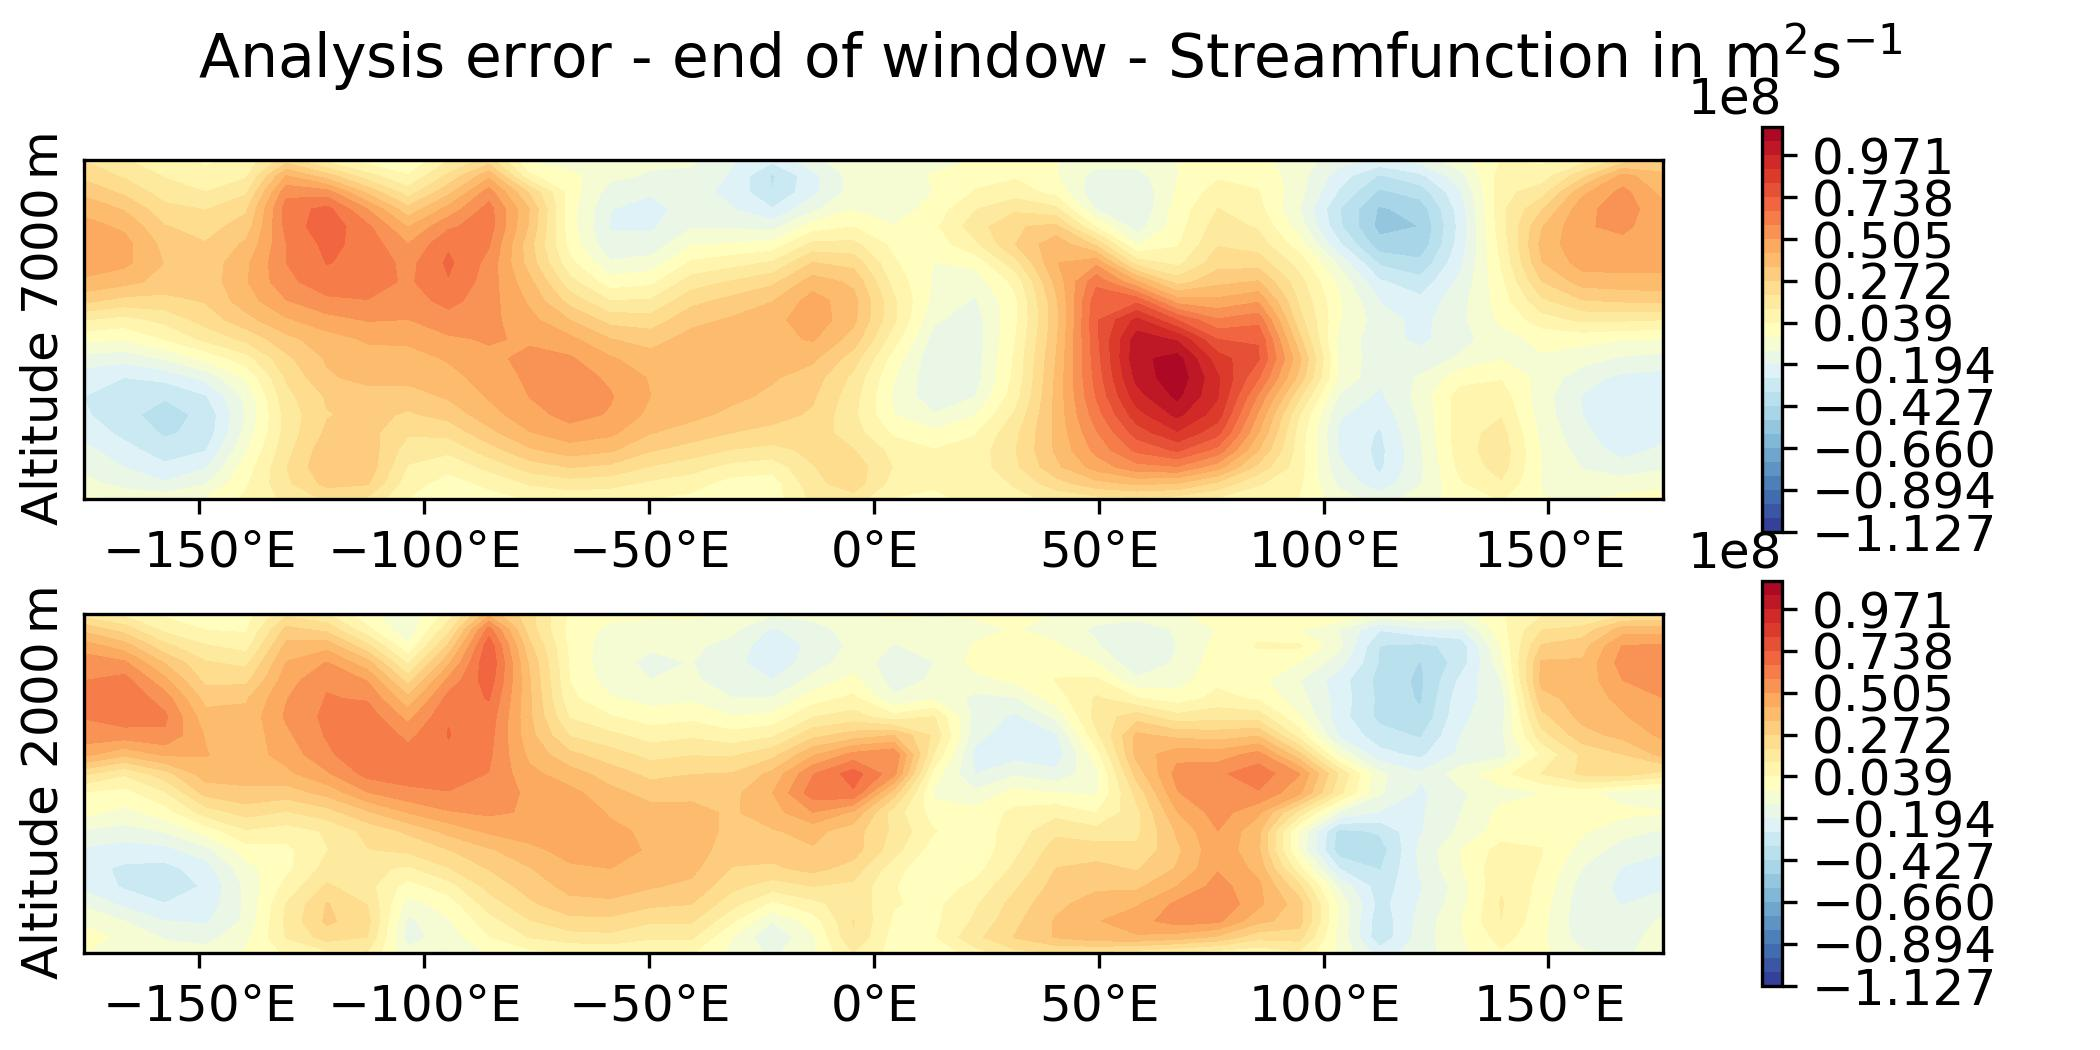

In [56]:
python ./plot.py qg fields \
        $JEDI_EDU/qg4Dvar/output/exp_mult/da/4dvar.multobs.an.2009-12-31T00\:00\:00Z.nc \
        $JEDI_EDU/qg4Dvar/output/truth/truth.fc.2009-12-15T00\:00\:00Z.P16D.nc \
        --fieldmax 112662784 \
        --output $JEDI_EDU/qg4Dvar/output/exp_mult/plots/4dvar_an_end --title "Analysis error - end of window"
display < $JEDI_EDU/qg4Dvar/output/exp_mult/plots/4dvar_an_end_x_diff.jpg

And forecast error:

Parameters:
 - model: qg
 - diagnostic: fields
 - filepath: /home/nonroot/shared/EDU/qg4Dvar/output/exp_mult/bg/bkgd.fc.2009-12-30T00:00:00Z.P1D.nc
 - basefilepath: /home/nonroot/shared/EDU/qg4Dvar/output/truth/truth.fc.2009-12-15T00:00:00Z.P16D.nc
 - fieldmax: 112662784
 - plotObsLocations: None
 - plotwind: False
 - gif: None
 - output: /home/nonroot/shared/EDU/qg4Dvar/output/exp_mult/plots/4dvar_fc_end
 - title: Forecast error - end of window
Run script
['/home/nonroot/shared/EDU/qg4Dvar/output/exp_mult/bg/bkgd.fc.2009-12-30T00:00:00Z.P1D.nc']
range: 112662784
 -> plot produced: /home/nonroot/shared/EDU/qg4Dvar/output/exp_mult/plots/4dvar_fc_end_x_diff.jpg
range: 112662784
 -> plot produced: /home/nonroot/shared/EDU/qg4Dvar/output/exp_mult/plots/4dvar_fc_end_q_diff.jpg
range: 112662784
 -> plot produced: /home/nonroot/shared/EDU/qg4Dvar/output/exp_mult/plots/4dvar_fc_end_u_diff.jpg
range: 112662784
 -> plot produced: /home/nonroot/shared/EDU/qg4Dvar/output/exp_mult/plots/4dvar_fc_en

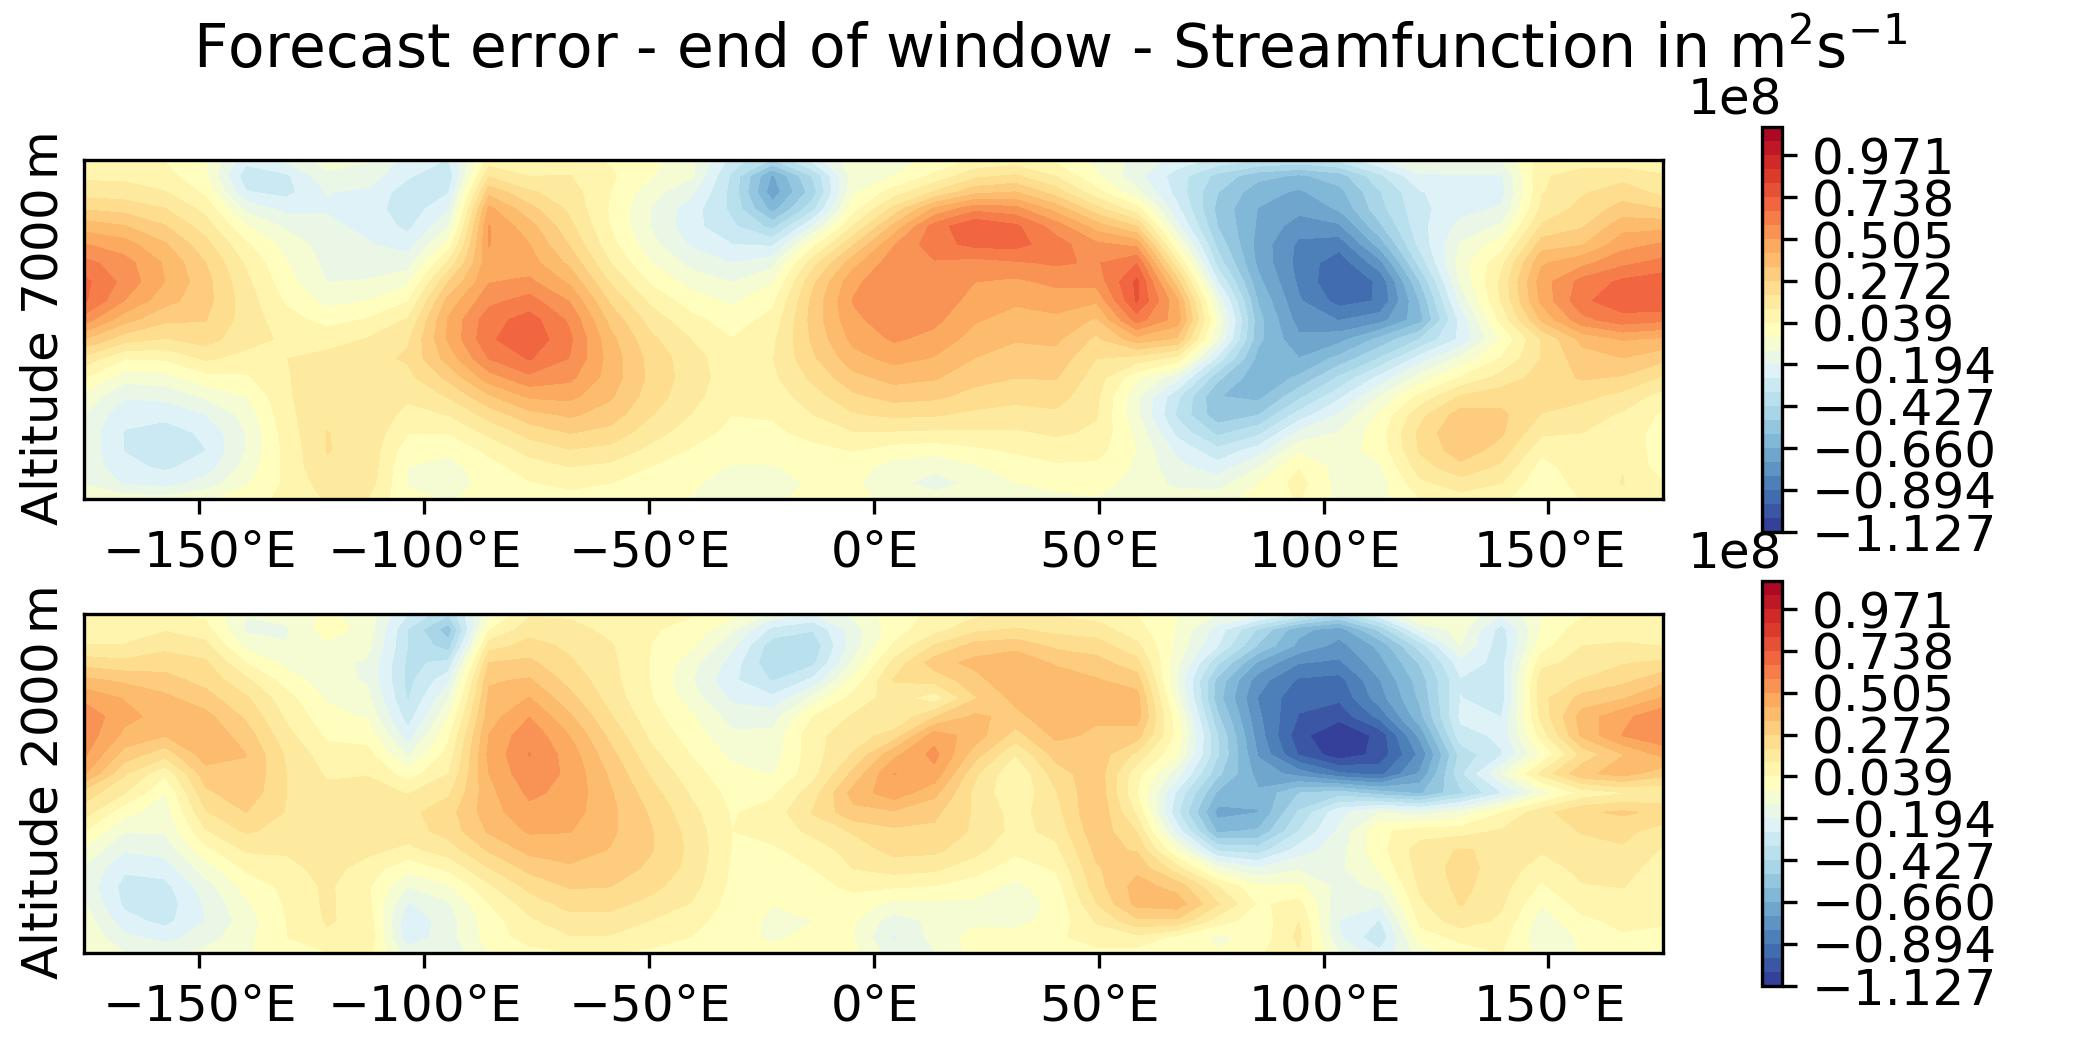

In [57]:
python ./plot.py qg fields \
        $JEDI_EDU/qg4Dvar/output/exp_mult/bg/bkgd.fc.2009-12-30T00:00:00Z.P1D.nc \
        $JEDI_EDU/qg4Dvar/output/truth/truth.fc.2009-12-15T00\:00\:00Z.P16D.nc \
        --fieldmax 112662784 \
        --output $JEDI_EDU/qg4Dvar/output/exp_mult/plots/4dvar_fc_end --title "Forecast error - end of window"
display < $JEDI_EDU/qg4Dvar/output/exp_mult/plots/4dvar_fc_end_x_diff.jpg